  <style>
    .container {
      display: flex;
      gap: 10px; /* Optional spacing between divs */
    }

    .box h1 {
      font-size: 50px;
      padding-top: 10px;
      font-weight: 600;
    }
  </style>
  <div class="container" style="">
    <div class="box">
      <h1>Planning for Robotics</h1>
    </div>
    <div class="box" align="right">
      <img src="images/template/course_logo.svg" alt="Planning for Robotics" height="70"/>
      &nbsp;&nbsp;&nbsp;&nbsp;
      <img src="images/template/logo_i6.svg" alt="Chair Logo" height="70"/>
      &nbsp;&nbsp;&nbsp;&nbsp;
    </div>
  </div>


# Exercise Sheet 3 - Navigation and Path Planning

In [1]:
%matplotlib inline

## Introduction
In mobile robots, navigation is about getting a robot from one location to another location. Whereas in motion planning we were considering problems like moving a robot arm, here we are more interested in getting from one room to another room, or from one building to another building. Navigation competence is actually the first type of higher-level deliberation system that we are considering here. In fact, it consists of two different types of competencies: path planning, and obstacle avoidance. As such, we are looking into a much more coarse level of abstraction. 

In this week's exercise we are looking into discretisation of environments, global path planning, and local obstacle avoidance. We will specifically not look into the localisation and mapping problems, though I do recommend a look into the book "Probabilistic Robotics" in case you are interested.  

### Learning Objectives
- Learn about map discretisation 
- Implement path finding algorithms
- React to local obstacles by performing local collision avoidance


### Acknowledgments
This exercise is largely based on contents from "Introduction to Autonomous Mobile Robots" by Siegwart et al. as well as "Planning Algorithms" by Steven LaValle, and Modern Robotics by Kevin Lynch and Frank Park.

In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [3]:
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import heapq
import time
from IPython.display import clear_output
import random
from collections import deque

## Task 0: Environment Creation
In the following tasks you will need to create a path planning environment using `matplotlib`
Create your own 2D environment and visualisation function here. You can build on your previously developed tools.

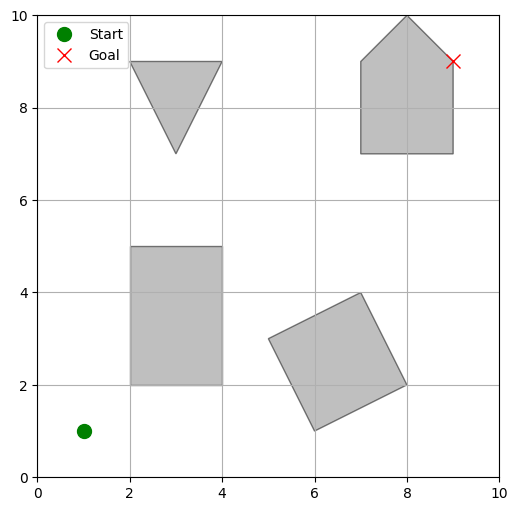

In [4]:
# 1) Environment creation
def create_environment():
    bounds = (0, 10, 0, 10)
    obstacles = [
        [(2, 2), (4, 2), (4, 5), (2, 5)],          # rectangle
        [(6, 1), (8, 2), (7, 4), (5, 3)],          # irregular quadrilateral
        [(3, 7), (4, 9), (2, 9)],                  # triangle
        [(7, 7), (9, 7), (9, 9), (8, 10), (7, 9)]   # pentagon
    ]
    start = (1, 1)
    goal = (9, 9)
    return obstacles, bounds, start, goal

# 2) Visualization
def plot_environment(obstacles, bounds, start=None, goal=None):
    xmin, xmax, ymin, ymax = bounds
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.grid(True)

    for obs in obstacles:
        patch = patches.Polygon(obs, closed=True,
                                edgecolor='black',
                                facecolor='gray',
                                alpha=0.5)
        ax.add_patch(patch)

    if start:
        ax.plot(start[0], start[1], 'go', markersize=10, label='Start')
    if goal:
        ax.plot(goal[0], goal[1], 'rx', markersize=10, label='Goal')

    if start or goal:
        ax.legend(loc='upper left')

    plt.show()

# 3) Demonstration
obstacles, bounds, start, goal = create_environment()
plot_environment(obstacles, bounds, start, goal)


## Task 1: Map Discretisation
A *grid map*, or occupancy grid, represents the environment as a two-dimensional array of discrete cells. This differs from the configuration space representations discussed earlier, which typically do not involve any discretisation.

<div style="text-align: center;">
    <img src="images/maps.png" width="500" />
    
An example of lossy abstraction in a discrete grid map, leading ot the loss of a narrow passageway. From "Autonomous Mobile Robots" by Siegwart et al.
</div>

The simplest form of spatial discretisation is a uniform grid. In navigation tasks, we often restrict ourselves to a 2D grid representation. This enables the use of classical graph search algorithms such as A* or Dijkstra’s algorithm to compute paths to a target location.

However, before such algorithms can be applied, several decisions must be made regarding the grid structure:
- **Connectivity:** Should the grid be 4-connected (movement allowed in cardinal directions only) or 8-connected (including diagonal movements)?
- **Resolution:** What cell size should the grid use? The choice of resolution has important implications. For instance, grid-based planners like A* are resolution complete, meaning they will find a solution if one exists at the selected level of discretisation.

There are three key considerations when choosing a suitable resolution and representation:
1.	The map’s precision should match the precision required to achieve the robot’s goals.
2.	The features and resolution of the map should align with the quality and granularity of the robot’s sensor data.
3.	The complexity of the map representation directly affects the computational cost of navigation, localisation, and other tasks.

Grid-based representations are commonly referred to as fixed decompositions, where the continuous real-world environment is approximated using a discrete structure. This approximation is inherently lossy—for example, narrow passageways may be lost during discretisation. Nonetheless, grid maps remain an effective approach due to their simplicity and efficiency in planning, mapping, and localisation tasks.

Generally, many of the parameters depend on robot hardware, use-cases, and desired behaviour. In the following exercises you will explore grid maps and discretisation of polynomial obstacles. 

### Coding Task 1.1 - 2D Map
In this task you should implement a `GridMap` class that can be initialised with a height, width, and resolution. Add methods to set cells to an obstacle, to check whether a cell is free. Also add methods t visualise the map (including a path of cells, and a robot position) for later tasks.

In [5]:
class GridMap:
    #Your Code Goes in the sections Below
    def __init__(self, width, height, resolution=1.0, origin=(0.0, 0.0)):
        """
        Initialize a 2D occupancy grid map.
        :param width: Width of the map in number of cells.
        :param height: Height of the map in number of cells.
        :param resolution: Size of each cell (meters per cell).
        """
        self.width = width
        self.height = height
        self.resolution = resolution
        self.origin = origin
        self.grid = np.zeros((height, width), dtype=np.uint8)  # 0 = free, 1 = obstacle

    def set_obstacle(self, x, y):
        """
        Mark the cell (x, y) as occupied.
        """
        if 0 <= x < self.width and 0 <= y < self.height:
            self.grid[y, x] = 1

    def is_free(self, x, y):
        """
        Check if the cell (x, y) is free.
        """
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.grid[y, x] == 0
        return False
    
    def world_to_cell(self, x, y):
        """Convert world coords to cell indices."""
        ix = int((x - self.origin[0]) / self.resolution)
        iy = int((y - self.origin[1]) / self.resolution)
        return ix, iy

    def cell_to_world(self, ix, iy):
        """Convert cell indices to world‐coord at center."""
        x = self.origin[0] + (ix + 0.5)*self.resolution
        y = self.origin[1] + (iy + 0.5)*self.resolution
        return x, y

    def visualize(self, path=None, start=None, goal=None, ax=None, show=True):
        """Plot the grid, optional path (in world coords), start/goal."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        extent = [
            self.origin[0],
            self.origin[0] + self.width*self.resolution,
            self.origin[1],
            self.origin[1] + self.height*self.resolution
        ]
        ax.imshow(self.grid, cmap='gray_r', origin='lower', extent=extent)

        # grid lines
        major = np.arange(extent[0], extent[1]+1e-6, 1.0)
        minor = np.arange(extent[0], extent[1]+1e-6, self.resolution)
        ax.set_xticks(major); ax.set_yticks(major)
        ax.set_xticks(minor, minor=True); ax.set_yticks(minor, minor=True)
        ax.grid(which='major', color='black', linewidth=1)
        ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

        # draw path
        if path:
            # convert cells -> world points
            xs, ys = zip(*[self.cell_to_world(ix,iy) for ix,iy in path])
            ax.plot(xs, ys, '-r', linewidth=2, label='A* path')

        # start/goal markers
        if start:
            sx, sy = self.cell_to_world(*start)
            ax.plot(sx, sy, 'go', markersize=8, label='start')
        if goal:
            gx, gy = self.cell_to_world(*goal)
            ax.plot(gx, gy, 'rx', markersize=8, label='goal')

        ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
        if path or start or goal:
            ax.legend(loc='upper left')
        if show:
            plt.show()
        else:
            ax.figure.canvas.draw()
    
    

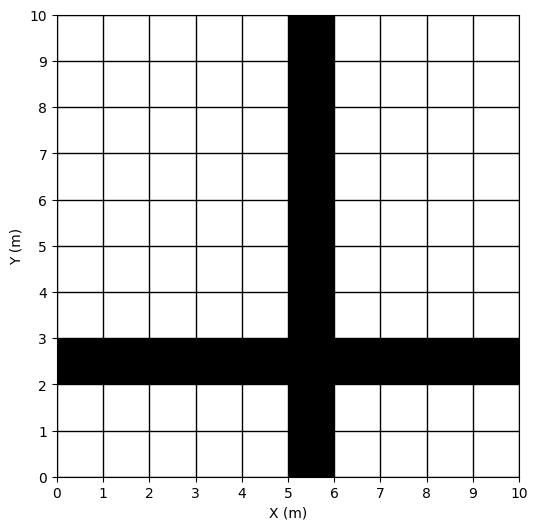

In [6]:
# Create a 10x10 grid map
grid = GridMap(width=10, height=10, resolution=1)

# Set a vertical wall at column x = 5
for y in range(grid.height):
    grid.set_obstacle(5, y)

# Set a horizontal wall at row y = 2
for x in range(grid.width):
    grid.set_obstacle(x, 2)

# Visualize the result
grid.visualize()


In [7]:
# Check some cells
print("Is (4, 2) free?", grid.is_free(4, 2))  # False
print("Is (1, 1) free?", grid.is_free(1, 1))  # True

Is (4, 2) free? False
Is (1, 1) free? True


### Coding Task 1.2 - Occupancy Grid Mapping
Using the previously discussed occupancy grid map, turn a set of polygonal obstacles into occupancy values for the map. Define the obstacles first, then fill in your map with the obstacles, and show the result. One simple way of performing the discretisation of obstacles is to query whether the center point of the grid cell is in the polygon. This, depending on the grid size, is an optimistic approach.

In [8]:
def add_polygon_obstacle_to_grid(gridmap, polygon, origin=(0, 0)):
    """
    Rasterize a polygonal obstacle into the gridmap.
    :param gridmap: Instance of GridMap.
    :param polygon: A shapely.geometry.Polygon object.
    :param origin: Origin of world coordinates (for future use).
    """
    for iy in range(gridmap.height):
        for ix in range(gridmap.width):
            cx = gridmap.origin[0] + (ix + 0.5)*gridmap.resolution
            cy = gridmap.origin[1] + (iy + 0.5)*gridmap.resolution
            if polygon.contains(Point(cx, cy)):
                gridmap.set_obstacle(ix, iy)

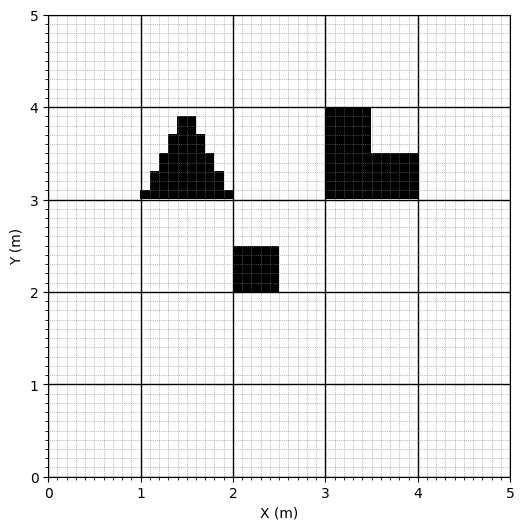

In [9]:
# Create a grid map 5m x 5m area
# Create a 5m x 5m grid at 0.1m resolution => 50x50 cells
res = 0.1
width, height = int(5.0/res), int(5.0/res)
grid = GridMap(width=width, height=height, resolution=res, origin=(0.0,0.0))

# Define polygonal obstacles
square = Polygon([(2.0, 2.0), (2.5, 2.0), (2.5, 2.5), (2.0, 2.5)])
triangle = Polygon([(1.0, 3.0), (1.5, 4.0), (2.0, 3.0)])
l_shape = Polygon([(3.0, 3.0), (4.0, 3.0), (4.0, 3.5), (3.5, 3.5), (3.5, 4.0), (3.0, 4.0)])

# Add them to the grid
# Rasterize obstacles
for poly in (square, triangle, l_shape):
    add_polygon_obstacle_to_grid(grid, poly)

# Visualize the resulting grid
grid.visualize()


## Task 2: Path Planning
Once we have our discretisation in form of a grid in place, we can now look into the path planning problem itself. As mentioned in the introduction, we treat path planning again as a search problem. 
It's easy to see how a grid is just a graph, once we determined the connectedness, so we can just rely on the vast set of efficient graph search algorithms. In this specific case, we want to move from an initial position in the grid, to a goal position in the grid (i.e., from one node to another), using a connected path and minimizing cost. In the base case, we assume uniform cost for every transition. However, the cost can be used as a tool to modify the behaviour of the plannner (e.g., to keep more distance to an obstacle).


### The A* Algorithm
<div style="text-align: center;">
    <img src="images/robot_astar.gif" width="500" />
    
An example of the A* algorithm performing search in an 8-connected grid. From ["MIT Class 865.21"](https://fab.cba.mit.edu/classes/865.21/topics/path_planning/robotic.html)
</div>
One of the most well known graph search algorithms that we can use for this purpose is A*. It combines the optimality of Dijkstra’s algorithm (a forward search algorithm) with the efficiency of Greedy Best-First Search.

Let $(V,E)$ be the input graph, $X_G$ be the set of goal states and $x_0$ the initial state. 
Let $l(e)$ bet the cost associated with $e \in E$ and $C^*:V \to [0, \infty]$ be the optimal cost-to-come function, that is the sum of all edge costs $l(e)$ over the most optimal path from $x_0$ to the selected $x \in V$. If $C^*(x)$ is not known yet, we refer to $C(x)$, the best known cost so far. 

Now let $G(x)$ denote the cost-to-go from $x$ to some state in $X_G$. Since we can not know $G(x)$ while performing search, we need to estimate it. For this we can use a heuristic function. However, this heuristic function needs to fulfill certain criteria which we call admissability. A heuristic is admissable if it always underestimates the true cost-to-go, thus not preventing the expansion of the actual optimal path. Of course, one underestimate is to always assign the value $0$, but we generally strive for a reasonable heuristic. If we choose an admissiable heuristic, then A* returns optimal paths. 

Let us now introduce the algorithm itself, which is mostly based on Dijkstra's aglorithm: Let us initialise a priority queue $Q$ (i.e., a queue that is ordered by each element's assigned priority value). Every entry $x' \in Q$ will be sorted according to the function $C^*(x') + G(x')$. 
Let's initialise $Q$ with our initial state $x_0$ and mark it as visited. We will now perform the following procedure:

In [10]:
def astar(grid, start, goal, diag=True):
    """
    A* search on the grid.
    :param start: (ix, iy) cell indices
    :param goal:  (ix, iy) cell indices
    :returns: list of (ix,iy) path from start to goal (inclusive), or [] if none
    """
    # Heuristic: Euclidean
    h = lambda a,b: np.hypot(a[0]-b[0], a[1]-b[1])

    # Neighbors: 4- or 8-connected
    moves = [(-1,0),(1,0),(0,-1),(0,1)]

    open_set = [(h(start, goal), 0.0, start, None)]
    came_from = {}       # cell -> parent
    cost_so_far = {start: 0.0}
    visited = set()

    while open_set:
        _, cost, current, parent = heapq.heappop(open_set)
        if current in visited:
            continue
        visited.add(current)
        came_from[current] = parent

        if current == goal:
            # reconstruct path
            path = []
            node = goal
            while node is not None:
                path.append(node)
                node = came_from[node]
            return path[::-1]

        for dx, dy in moves:
            nxt = (current[0]+dx, current[1]+dy)
            if not grid.is_free(*nxt):
                continue
            # movement cost
            step_cost = np.hypot(dx, dy)
            new_cost = cost_so_far[current] + step_cost
            if nxt not in cost_so_far or new_cost < cost_so_far[nxt]:
                cost_so_far[nxt] = new_cost
                priority = new_cost + h(nxt, goal)
                heapq.heappush(open_set, (priority, new_cost, nxt, current))

    # no path found
    return []

In [11]:
def simulate_path_following(gridmap, path, delay=0.2):
    """
    Step-by-step simulation of a robot following a path on a grid map.
    :param gridmap: GridMap instance.
    :param path: List of (x, y) cells.
    :param delay: Time between steps in seconds.
    """
    #Add your code here
    if not path:
        print("⚠️ 无有效路径")
        return
    
    # ---- 静态底图 ----
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(gridmap.grid, cmap='Greys', origin='lower')
    ax.set_xticks(np.arange(-0.5, gridmap.width, 1))
    ax.set_yticks(np.arange(-0.5, gridmap.height, 1))
    ax.grid(color='black', linewidth=0.5)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_aspect('equal')

    xs, ys = zip(*path)
    ax.plot(xs, ys, color='red', linewidth=3, alpha=1)     # 整条路径淡显
    ax.scatter(xs[0], ys[0], c='blue', marker='o', label='start')
    ax.scatter(xs[-1], ys[-1], c='red',  marker='x', label='goal')
    ax.legend()

    # ---- 动态机器人点 ----
    robot_dot, = ax.plot([xs[0]], [ys[0]], 'bo', markersize=10)  # 用列表包裹

    for (x, y) in path[1:]:
        robot_dot.set_data([x], [y])      # 关键修改：传列表
        clear_output(wait=True)
        display(fig)
        time.sleep(delay)

    clear_output(wait=True)
    display(fig)
    print("✅ ok")

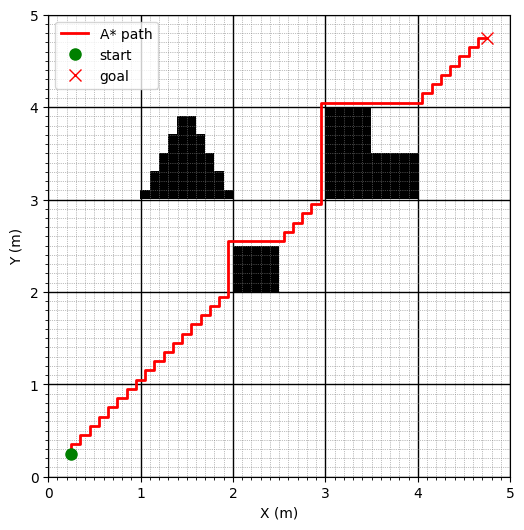

In [12]:
# 1) Build a 5×5 m grid @ 0.1 m resolution
res   = 0.1
W, H  = int(5.0/res), int(5.0/res)
grid  = GridMap(width=W, height=H, resolution=res, origin=(0.0,0.0))

# 2) Rasterize the example polygons
square   = Polygon([(2.0, 2.0), (2.5, 2.0), (2.5, 2.5), (2.0, 2.5)])
triangle = Polygon([(1.0, 3.0), (1.5, 4.0), (2.0, 3.0)])
l_shape  = Polygon([(3.0, 3.0), (4.0, 3.0),
                    (4.0, 3.5), (3.5, 3.5),
                    (3.5, 4.0), (3.0, 4.0)])
for poly in (square, triangle, l_shape):
    add_polygon_obstacle_to_grid(grid, poly)

# 3) Define start & goal in world coords → cells
start_world = (0.3, 0.3)
goal_world  = (4.7, 4.8)
start_cell  = grid.world_to_cell(*start_world)
goal_cell   = grid.world_to_cell(*goal_world)

# 4) Run A*
path = astar(grid, start_cell, goal_cell)

# 5) Visualize
grid.visualize(path=path, start=start_cell, goal=goal_cell)

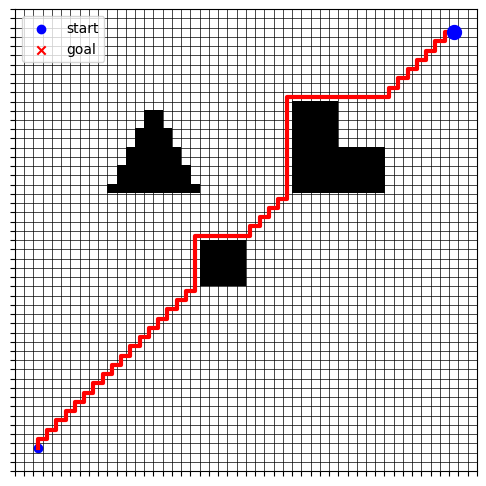

✅ ok


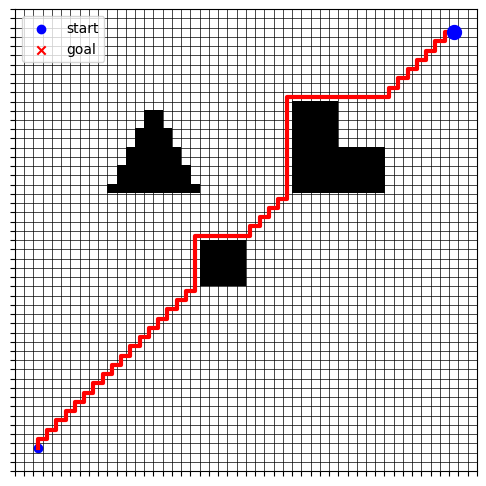

In [13]:
simulate_path_following(grid, path, delay=0.2)

In [14]:
# while Q not empty
# 	x <- first in Q
# 	if x \in X_G
# 		return SUCCESS
# 	for all x' \in SUCCESSSOR(x)
# 		if x' not visited
# 			mark x' as visited
# 			insert x' in $Q$
# 		else
# 			recompute C(x') and adapt priority

### Coding Task 2.1 - Global Path Planning with A*

Implement a global path planner using the A* search algorithm on the grid map:
- Implement A* for a 2D grid:
- Use 4-connected neighbors (optionally 8-connected).
- Manhattan distance as the default heuristic.
- Stop when the goal is reached.
- Visualize the resulting path.

Think about the following questions while doing your implementation:
- What happens if we use 8-connected neighbors?
- How does performance change with larger maps? What trade-offs arise between grid resolution and computational cost?
- When is the heuristic inadmissible? Why does Manhattan distance work well for grid maps?
- How can the cost be modified to keep the robot farther away from an obstacle?

In [15]:
def heuristic(a, b):
    """
    Compute Manhattan distance.
    """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, start, goal, diag=True):
    """
    A* search on the grid.
    :param start: (ix, iy) cell indices
    :param goal:  (ix, iy) cell indices
    :returns: list of (ix,iy) path from start to goal (inclusive), or [] if none
    """

    # Neighbors: 4- or 8-connected
    moves = [(-1,0),(1,0),(0,-1),(0,1)]

    open_set = [(heuristic(start, goal), 0.0, start, None)]
    came_from = {}       # cell -> parent
    cost_so_far = {start: 0.0}
    visited = set()

    while open_set:
        _, cost, current, parent = heapq.heappop(open_set)
        if current in visited:
            continue
        visited.add(current)
        came_from[current] = parent

        if current == goal:
            # reconstruct path
            path = []
            node = goal
            while node is not None:
                path.append(node)
                node = came_from[node]
            return path[::-1]

        for dx, dy in moves:
            nxt = (current[0]+dx, current[1]+dy)
            if not grid.is_free(*nxt):
                continue
            # movement cost
            step_cost = np.hypot(dx, dy)
            new_cost = cost_so_far[current] + step_cost
            if nxt not in cost_so_far or new_cost < cost_so_far[nxt]:
                cost_so_far[nxt] = new_cost
                priority = new_cost + heuristic(nxt, goal)
                heapq.heappush(open_set, (priority, new_cost, nxt, current))

    # no path found
    return []

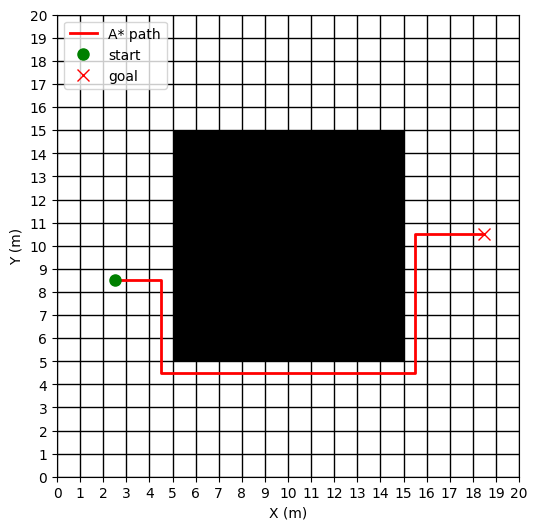

In [16]:
# Create a new map 20 x 20 and add an obstacle of size 10 in the middle
res   = 1
W, H  = int(20.0/res), int(20.0/res)
grid  = GridMap(width=W, height=H, resolution=res, origin=(0.0,0.0))

start = (2, 8)
goal = (18, 10)

# Add central 10x10 obstacle
for x in range(5, 15):
    for y in range(5, 15):
        grid.set_obstacle(x, y)

# Run A* and visualize
path = astar(grid, start, goal)
grid.visualize(path=path, start=start, goal=goal)

### Coding Task 2.2 - Visual Path Following Simulation 

Simulate a robot following the path returned by your A* planner, and visualize the movement step-by-step using matplotlib.

Make sure that:
- The robot is a point robot occupying one grid cell.
- The path is valid and free of obstacles.
- The robot follows the path sequentially, one cell per frame.

In [ ]:
def simulate_path_following(gridmap, path, delay=0.2):
    """
    Step-by-step simulation of a robot following a path on a grid map.
    :param gridmap: GridMap instance.
    :param path: List of (x, y) cells.
    :param delay: Time between steps in seconds.
    """
    #Add your code here
    if not path:
        print("NO PATH BRO!")
        return
    
    # ---- 静态底图 ----
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(gridmap.grid, cmap='Greys', origin='lower')
    ax.set_xticks(np.arange(-0.5, gridmap.width, 1))
    ax.set_yticks(np.arange(-0.5, gridmap.height, 1))
    ax.grid(color='black', linewidth=0.5)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_aspect('equal')

    xs, ys = zip(*path)
    ax.plot(xs, ys, color='purple', linewidth=2, alpha=1)     # 整条路径淡显
    ax.scatter(xs[0], ys[0], c='blue', marker='o', label='start')
    ax.scatter(xs[-1], ys[-1], c='red',  marker='x', label='goal')
    ax.legend()

    # ---- 动态机器人点 ----
    robot_dot, = ax.plot([xs[0]], [ys[0]], 'bo', markersize=10)  # 用列表包裹

    for (x, y) in path[1:]:
        robot_dot.set_data([x], [y])      # 关键修改：传列表
        clear_output(wait=True)
        display(fig)
        time.sleep(delay)

    clear_output(wait=True)
    display(fig)
    print("✅ ok")


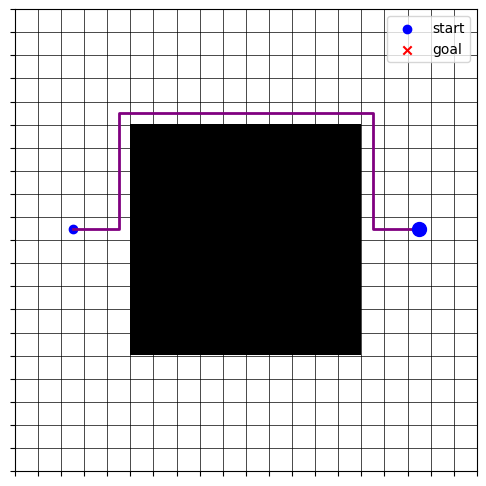

✅ ok


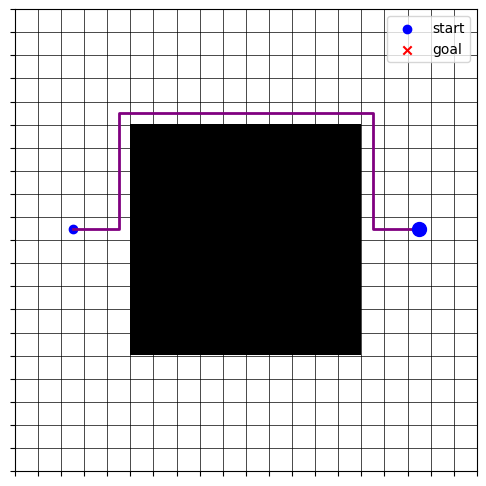

In [18]:
# Reuse map, start, goal, and A* path from Task 2
start = (2, 10)
goal = (17, 10)

#compute the path
path = astar(grid, start, goal)

#simulate the path
simulate_path_following(grid, path, delay=0.1)

## Task 3: Collision Avoidance and the Bug2 Algorithm
One of the big problem with path planning is that it is mostly static. I.e., given our static map, we perform one-shot planning to find a path. This naive approach works well in very controlled environments, but does not generalise to the complexity of real world scenarios. Often, a robot might have to deal with unknown static obstacles or even other dynamic agents that block its path, forcing it to stop or take a detour to avoid collision.

Robots typically have a set of different sensors that they can use to sense their surrounds. These sensors, often have a shorter range than the environment that the robot is interacting with, but they are very useful to perform local obstacle avoidance. I.e., changing the robot's trajectory away from the path to avoid collision. Many different obstacle avoidance algorithms exist, with many different degrees of complexity. Here we will focus on one of the easiest algorithms for collision avoidance: the Bug family of algorithms.

<div style="text-align: center;">
    <img src="images/bug2.png" width="500" />
    
An example of the Bug2 algorithm performing as it traverses around two obstacles. From "Introduction to Autonomous Mobile Robots" by Siegwart et al.
</div>

Bug1, the original algorithm in the family, tries to move the robot to the target in a straight line until it hits an obstacle. If an obstacle blocks the way, the robot fully circles it first, before it departs from the point with the shortest distance toward the goal. Bug2, is an improvement over this simple algorithm, instead of traveling the whole way around the obstacle, it moves directly towards the goal, once it is capable of it again. Bug2 does not require a map — only obstacle detection. The robot must only detect detect:
- The point of contact with an obstacle.
- Whether the direct line to the goal is free.

Bug2 can also be combined with a path planner. We can follow the path until we hit an obstacle. Once we hit it, we use Bug2's circling to move around the obstacle until we hit a cell that is part of the path again. You will try to variations of this in the following coding tasks. 

### Coding Task 3.1 - Implement the Bug2 Algorithm
In this task you are supposed to implement the Bug2 algorithm for collision avoidance. First, you must add another layer of obstacles that the A* planner from the previous task is "blind" to. Then you must follow this path, until you hit one of these secondary obstacles. In case of collision, use the Bug2 algorithm to follow the obstacles boundary (you can pick the direction), until you meet your planned path again. Use the visualisation tool from the previous task to animate the execution of your Bug2 algorithm.

Simulate a robot that:
1.	Computes a global path using A* on a known map.
2.	Follows the path, assuming it is correct.
3.	Encounters unexpected obstacles not included in the global map.
4.	Uses a Bug2-style local planner to bypass these obstacles and rejoin the original path.

Think about the following questions:
- Under what circumstances does Bug2 perform worse than A*?
- Is Bug2 guaranteed to find a path if one exists?

In [26]:
# ---------- Helper Functions ----------

def is_on_line(p, start, goal, tol=1e-6):
    """
    Check if point p is on the line segment [start, goal], within a tolerance.
    Uses cross product and checks bounds.
    """
    (x, y) = p
    (x1, y1) = start
    (x2, y2) = goal

    # Vector from start to p and from start to goal
    dxp, dyp = x - x1, y - y1
    dxg, dyg = x2 - x1, y2 - y1

    cross = dxp * dyg - dyp * dxg
    # On line if cross product is zero (or close)
    if abs(cross) > tol:
        return False

    # Check if p is between start and goal
    dot = dxp * dxg + dyp * dyg
    if dot < 0:
        return False # behind start
    squared_len = dxg**2 + dyg**2
    if dot > squared_len:
        return False # beyond goal
    return True

def bug2_detour(true_map, start, visited, rejoin_set, max_steps=500):
    """
    "Wall-follow" along the obstacle boundary, right-hand rule, until it can rejoin the path.
    - true_map: fully accurate map (including hidden obstacles)
    - start: current robot cell, where it encountered obstacle
    - visited: set of cells already visited on detour (to avoid looping)
    - rejoin_set: set of path cells (excluding the blocked cell) where allowed to jump back
    - returns: detour path (from starting cell, inclusive) that ends on a cell in rejoin_set
    """
    def neighbors8(x, y):
        for dx, dy in [(-1,0),(0,1),(1,0),(0,-1)]:
            yield x+dx, y+dy

    def is_boundary(cx, cy):
        """True if cell is obstacle, and at least one neighbor is free."""
        if not 0 <= cx < true_map.width or not 0 <= cy < true_map.height: return False
        if not true_map.grid[cy, cx]: return False
        for n in neighbors8(cx, cy):
            nx, ny = n
            if 0 <= nx < true_map.width and 0 <= ny < true_map.height and true_map.grid[ny, nx]==0:
                return True
        return False

    # Step 1: Find initial wall-following position ("trace obstacle edge from where we hit it")
    x0, y0 = start
    # Find the first free neighbor adjacent to an obstacle; start tracing from there.
    for dx, dy in [(-1,0),(0,1),(1,0),(0,-1)]:
        nx, ny = x0+dx, y0+dy
        if 0 <= nx < true_map.width and 0 <= ny < true_map.height:
            if true_map.grid[ny, nx]==0:
                break
    else:
        # no adjacent free cell; can't detour
        return []
    current = (x0+dx, y0+dy)
    path = [current]
    visited = set(visited) # for clarity

    # Right-hand rule (clockwise): try turn right, forward, left, back.
    direction = (dx, dy) 
    directions = [(-1,0),(0,1),(1,0),(0,-1)]

    for count in range(max_steps):
        # Can we rejoin the path (but not at starting cell)
        if current in rejoin_set and current != start:
            return path
        visited.add(current)
        x, y = current
        # Find which way we're facing
        dir_idx = directions.index(direction)
        found = False
        # Try right, forward, left, back
        for k in [1,0,-1,2]:
            d = directions[(dir_idx + k)%4]
            nx, ny = x + d[0], y + d[1]
            if (0 <= nx < true_map.width and 0 <= ny < true_map.height 
                and true_map.grid[ny, nx]==0 and (nx, ny) not in visited):
                direction = d
                current = (nx, ny)
                path.append(current)
                found = True
                break
        if not found:
            # Could not move; likely stuck
            break
    return []

def animate_step(true_map, executed_path, robot_pos, global_path, delay=0.2):
    plt.figure(figsize=(7,7))
    plt.imshow(true_map.grid, cmap='gray_r', origin='lower')
    xs, ys = zip(*executed_path)
    plt.plot(xs, ys, '-b', linewidth=2, label='Actual')
    if global_path:
        gx, gy = zip(*global_path)
        plt.plot(gx, gy, '--r', alpha=0.3, label='A* planned')
    plt.plot(robot_pos[0], robot_pos[1], 'go', markersize=14, label='Robot')
    plt.legend()
    plt.title("Bug2-Aware Reactive Path Execution")
    plt.grid(True)
    plt.show()
    time.sleep(delay)

def reactive_path_following(gridmap, true_map, path, delay=0.2):
    """
    Executes a global path, but when encountering an unexpected obstacle, does a Bug2-style detour.
    Visualization included.
    """
    executed = []
    path_set = set(path)
    idx = 0
    robot = path[idx]
    executed.append(robot)

    while idx < len(path)-1:
        nextcell = path[idx+1]
        # True map: is next step unexpectedly blocked?
        if not true_map.is_free(*nextcell):
            print(f"❌ Unexpected obstacle at {nextcell}, commence Bug2 detour!")
            # "Look ahead": only attempt to rejoin with future cells on the planned path.
            rejoin_set = set(path[idx+1:])
            detour = bug2_detour(true_map, robot, set(executed), rejoin_set)
            if not detour:
                print("❌ Bug2 detour failed, stuck.")
                animate_step(true_map, executed, robot, path, delay=1)
                break
            # Follow detour, stepwise animation
            for dcell in detour:
                executed.append(dcell)
                robot = dcell
                animate_step(true_map, executed, robot, path, delay)
            # Now, where are we?
            # Set index to cell we rejoined on
            idx = path.index(robot)
        else:
            robot = nextcell
            executed.append(robot)
            idx += 1
            animate_step(true_map, executed, robot, path, delay)
    print("✅ Finished!")
    return executed

# ---------- Example Run ----------

# Create a known 20x20 grid map for A* (width, height)
grid = GridMap(20, 20, resolution=1)

# Add a vertical wall in the middle but with a gap at row 10
for y in range(grid.height):
    if y != 10:
        grid.set_obstacle(10, y)



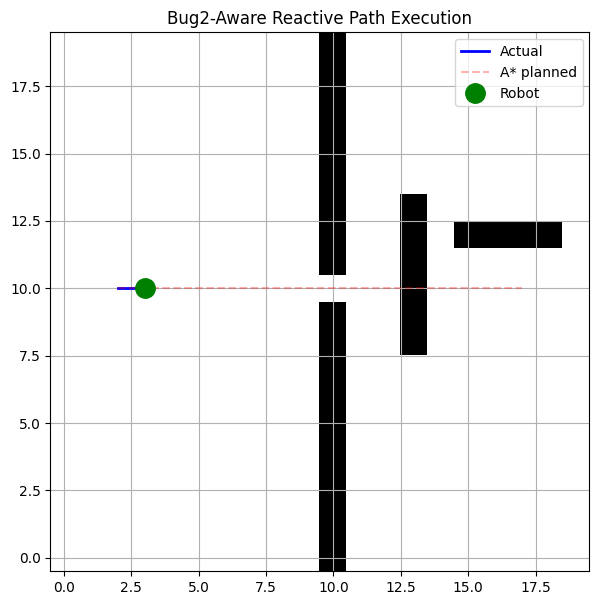

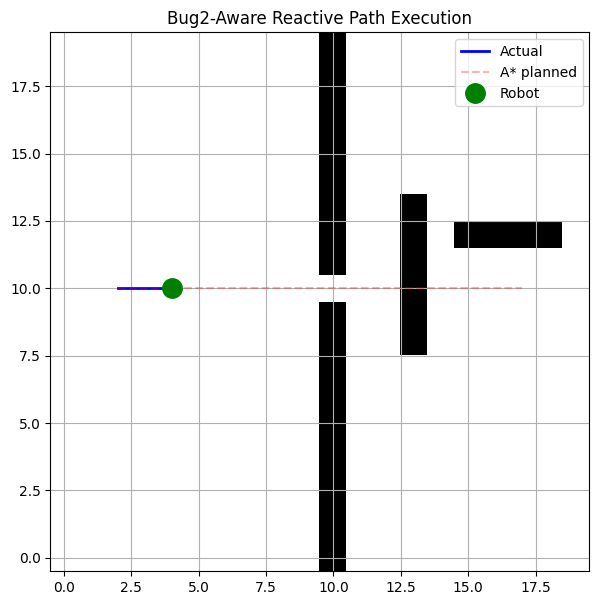

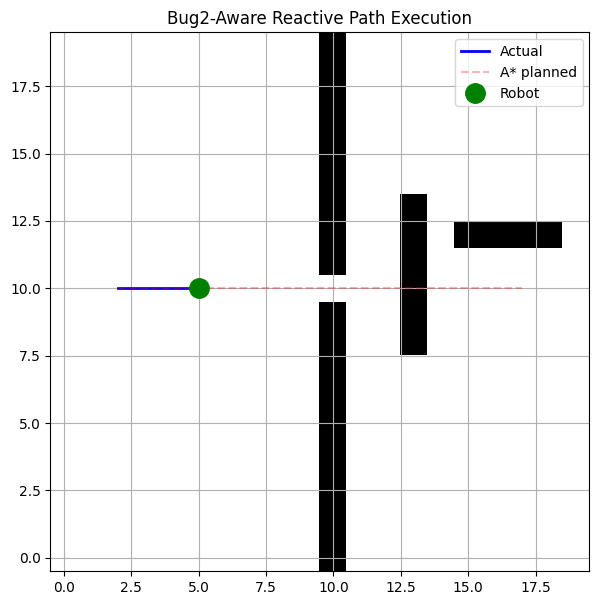

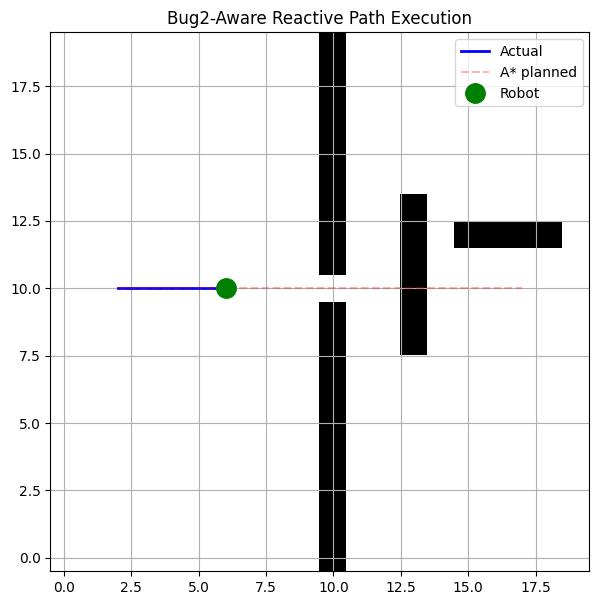

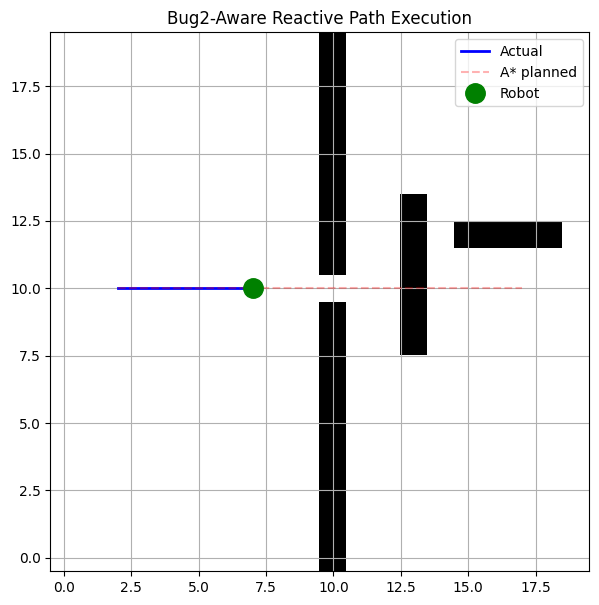

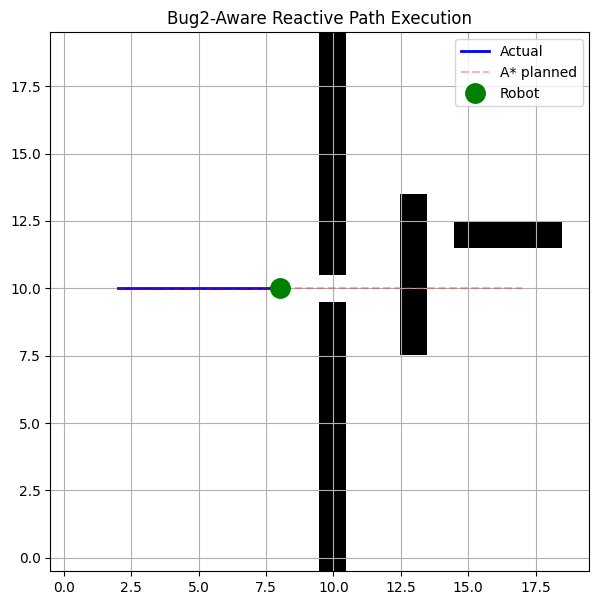

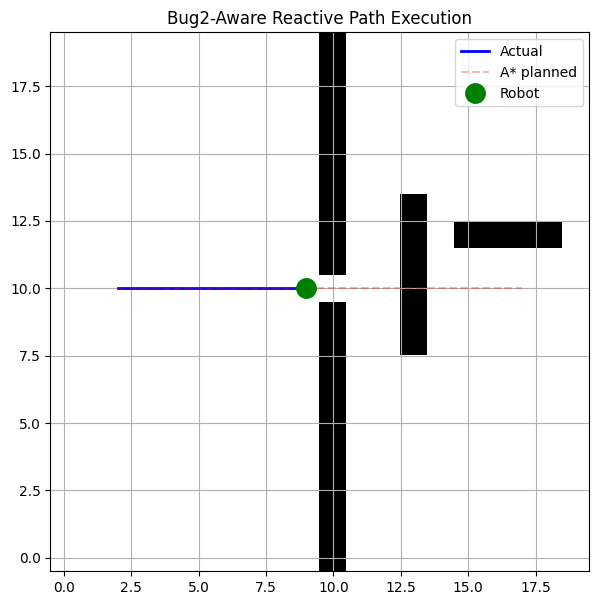

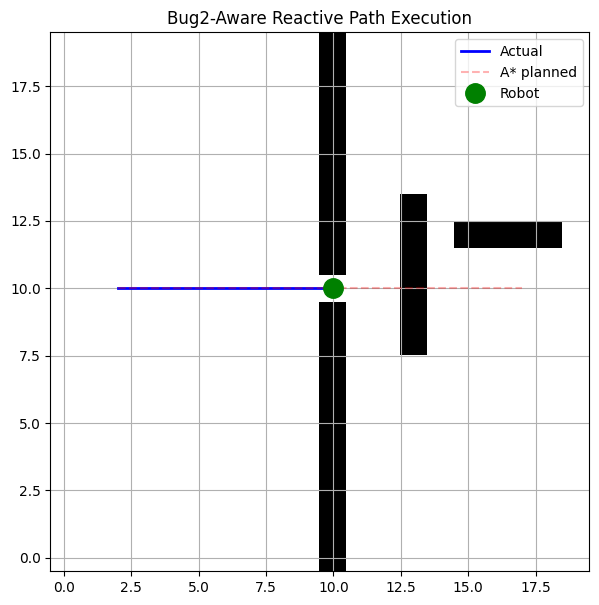

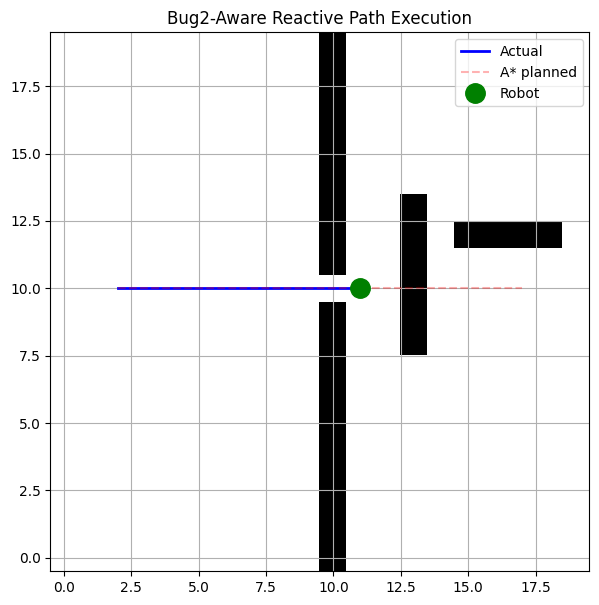

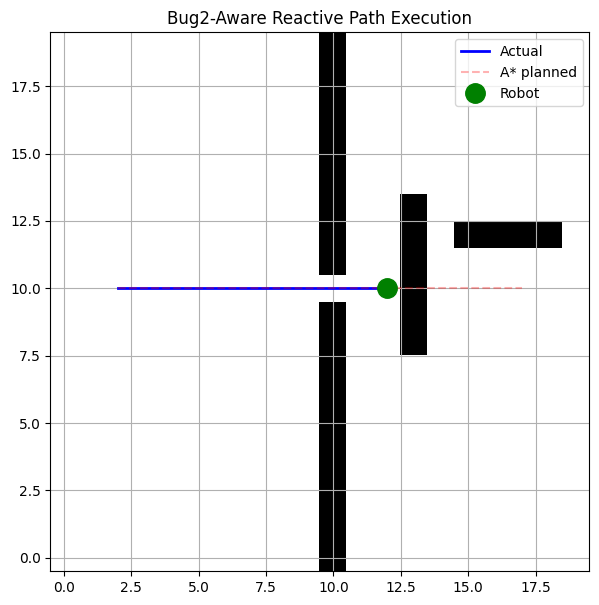

❌ Unexpected obstacle at (13, 10), commence Bug2 detour!


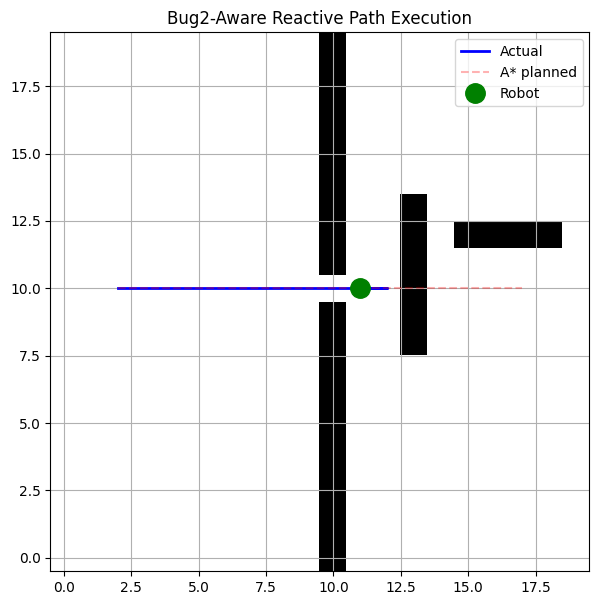

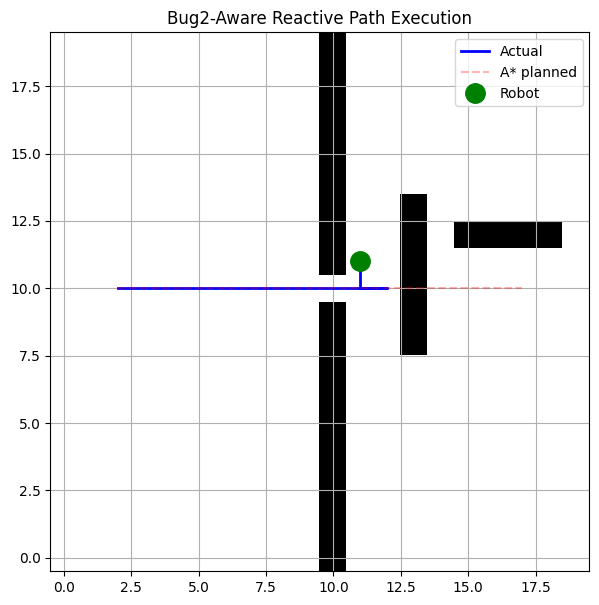

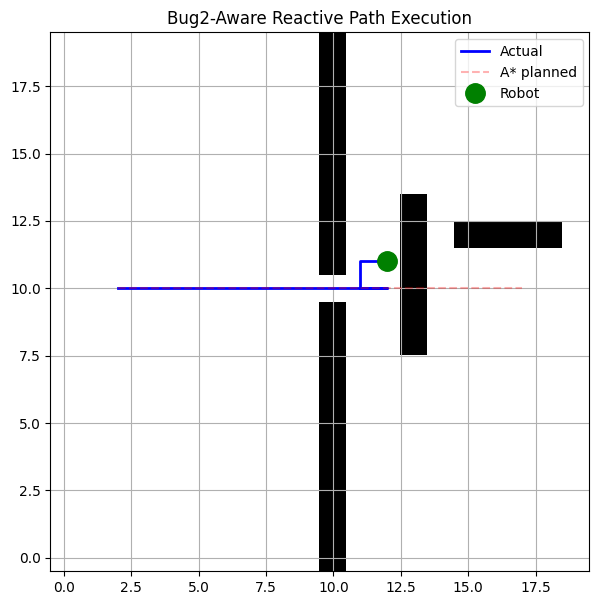

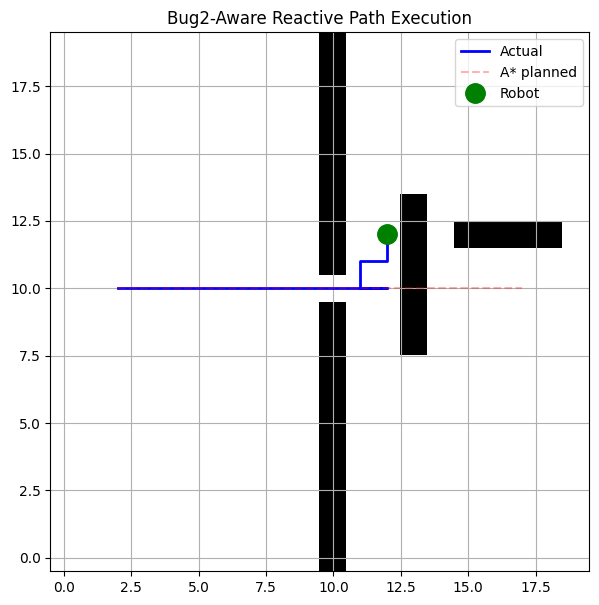

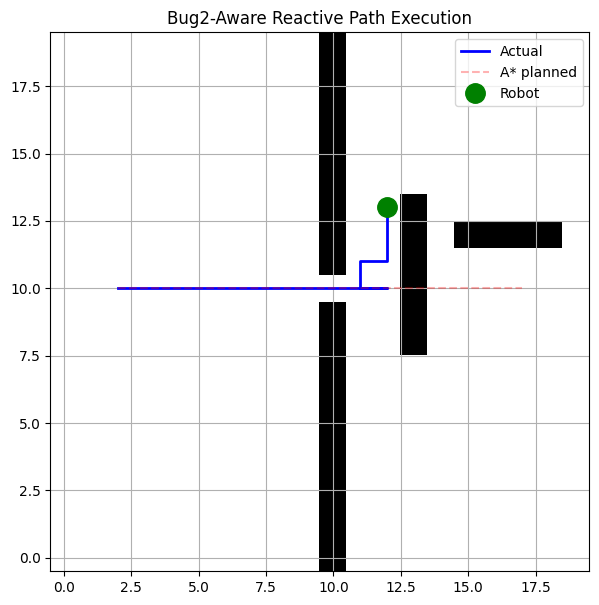

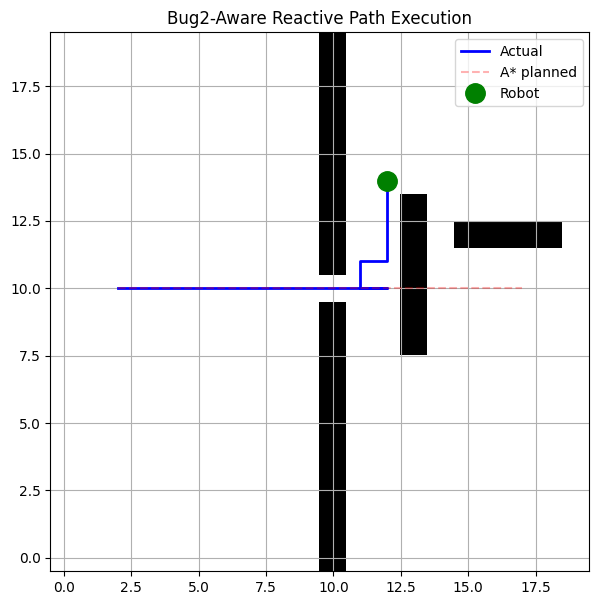

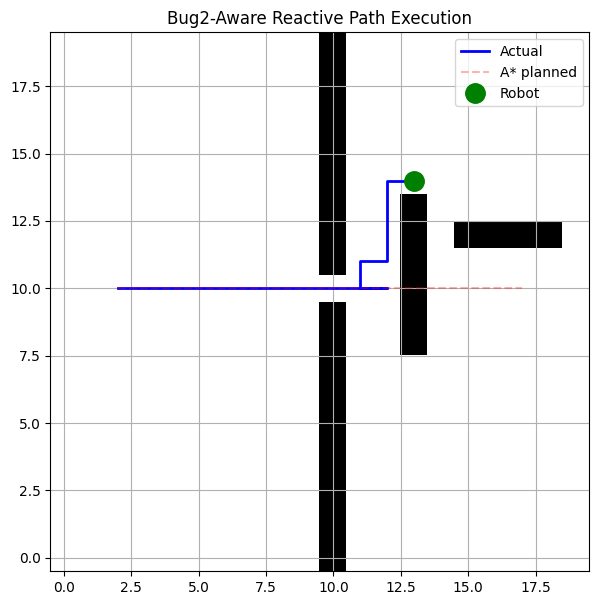

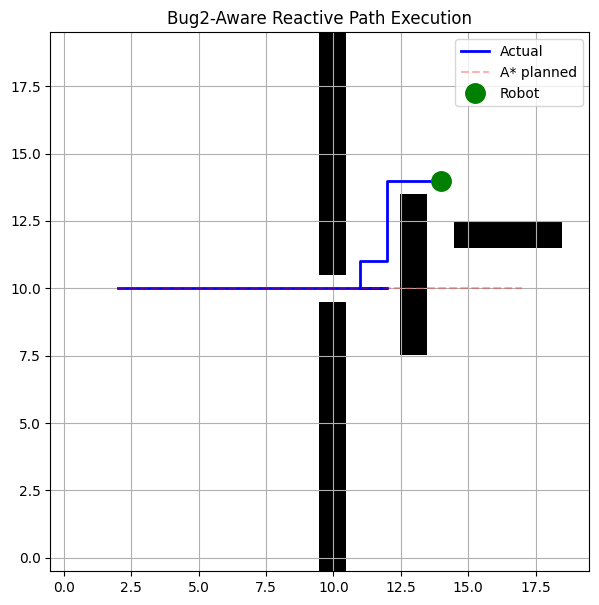

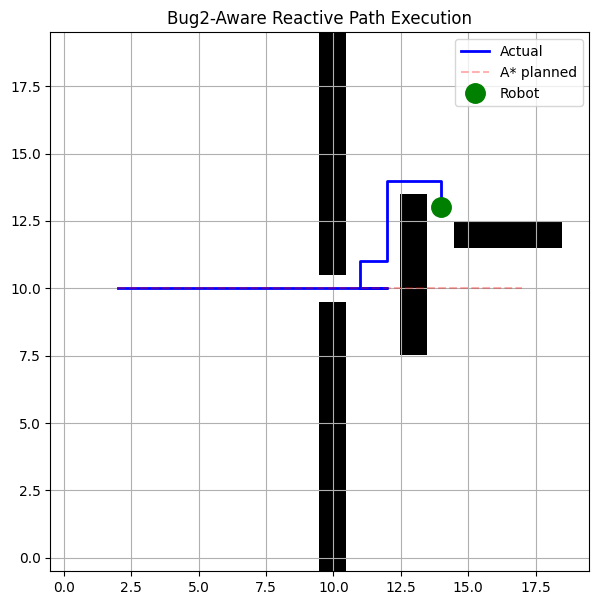

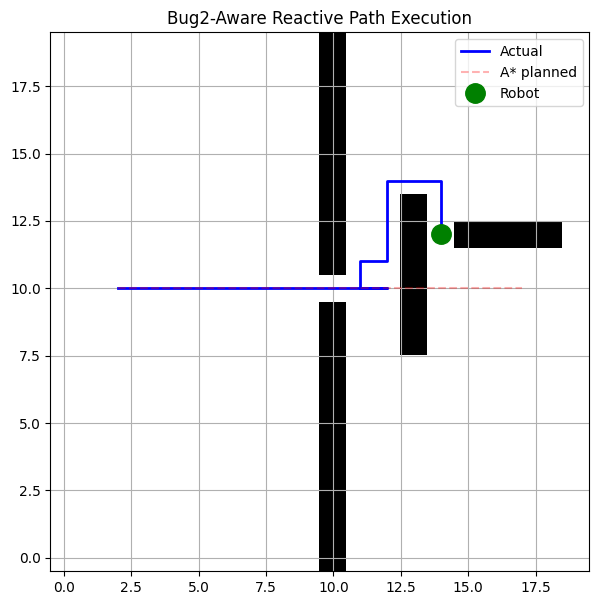

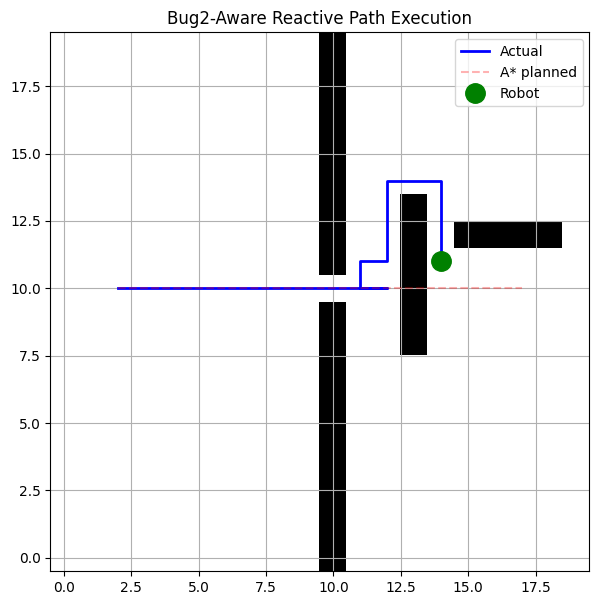

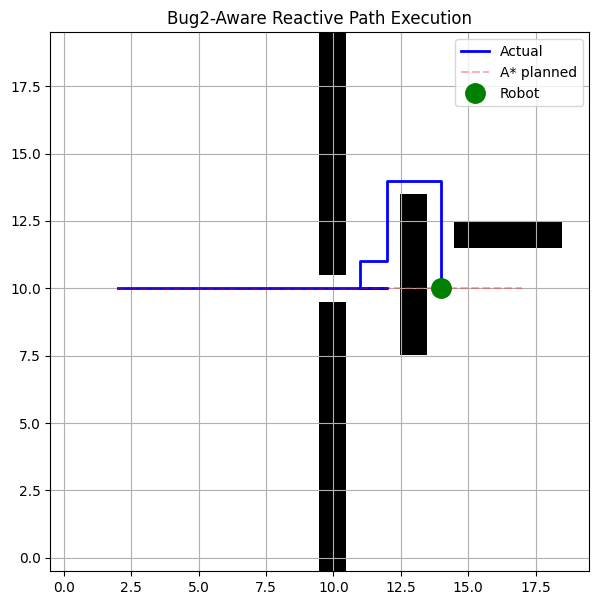

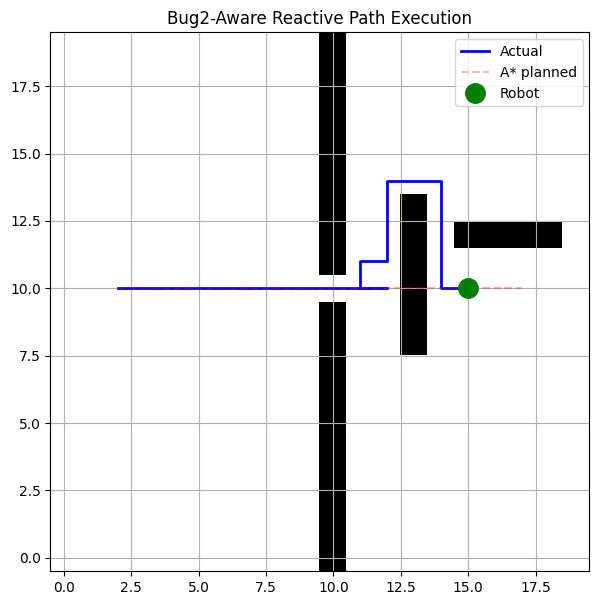

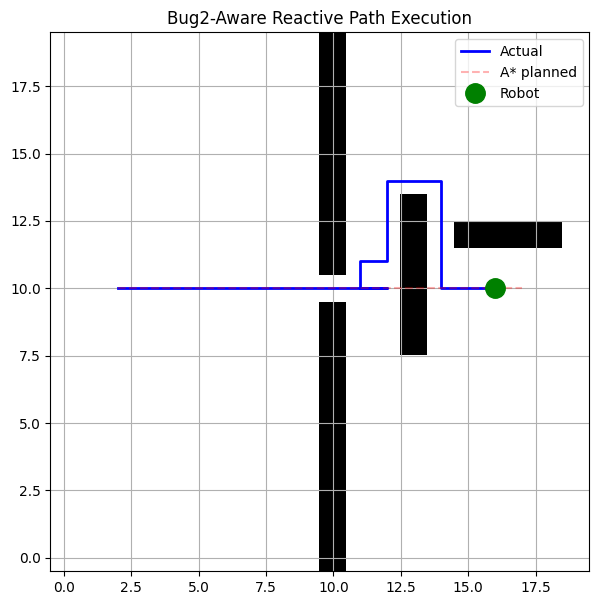

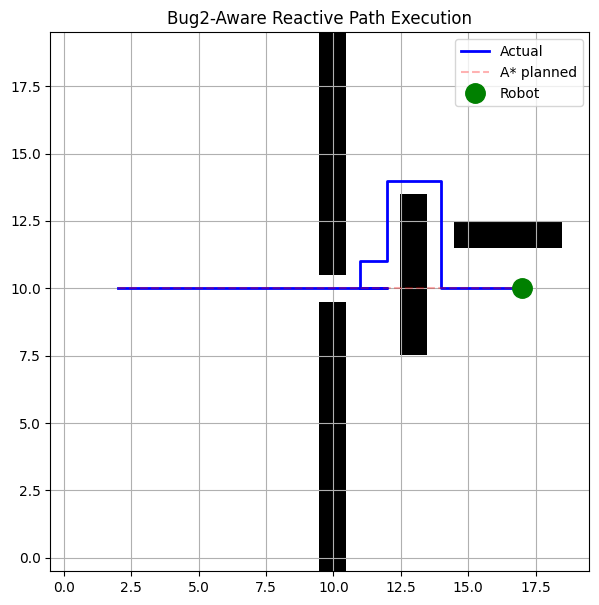

✅ Finished!


[(2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10),
 (11, 10),
 (12, 10),
 (11, 10),
 (11, 11),
 (12, 11),
 (12, 12),
 (12, 13),
 (12, 14),
 (13, 14),
 (14, 14),
 (14, 13),
 (14, 12),
 (14, 11),
 (14, 10),
 (15, 10),
 (16, 10),
 (17, 10)]

In [27]:
# Plan a path with A* (from (2,10) to (17,10)), not aware of any extra obstacles
start = (2, 10)
goal = (17, 10)
path = astar(grid, start, goal)

# "True" map shows unexpected obstacles not on the grid map
true_map = GridMap(20, 20, resolution=1)

# Copy obstacles from known grid
true_map.grid[:,:] = grid.grid
# Add NEW obstacle ("unknown" to the robot): rectangle in the way just right of the gap
for y in range(8, 14):
    true_map.set_obstacle(13, y)

# Another new obstacle
for x in range(15, 19):
    true_map.set_obstacle(x, 12)

# Animate robot following path and performing Bug2 avoidance upon collision
reactive_path_following(grid, true_map, path, delay=0.3)

### Coding Task 3.2 - Bug2 with Random Obstacles
Build on the previous example, where we had global and local obstacles, by introducing random obstacles within the "local-sensing range" of the robot. I.e., while executing, random obstacles appear near the robot. The robot must:
- Detect the new obstacle.
- Use Bug2 to locally avoid it.
- Resume following the global path.

This task models how a real robot might react to the sudden appearances of dynamic obstacles like humans crossing their path. Robots also usually have limited sensing ranges, meaning that they are unaware of obstacles until in range.

Think about the following questions:
- Is the robot guaranteed to reach the goal under continuous obstacle addition?
- How could this be extended to trigger local re-planning instead of Bug2?


In [21]:
#Add your code here
#create dynamic obstacles and add reactive path to show reactive path following with these dynamic obstacles
def dynamic_obstacle(true_map, robot_pos, chance=0.3, radius=2):
#Add your code here
def reactive_path_following_with_dynamic_obstacles(gridmap, true_map, path, delay=0.3):
#Add your code here

IndentationError: expected an indented block after function definition on line 3 (1465118649.py, line 5)

In [ ]:
# Grid known to the planner (same as before)
#Add your code here

# Global path from Task 2
start = (2, 10)
goal = (17, 10)


# True map (no dynamic obstacles yet)
#Add your code here

# Run with dynamic events
#Add your code here

## Submission Checklist
- [ ] All of the coding tasks are completed
- [ ] You can show the visualisations and animations as requested
- [ ] You can confidently provide answers to the questions posed in the tasks